# Binding energy calculation

## Justification

For two interacting RNAs, their binding energy and thus likelihood of interacting may be found through a variety of RNA simulators. In practice, this binding energy $\Delta G$ may translate into actual binding and subsequent repression in a genetic circuit through the forward and reverse equilibrium rates of the reaction. Both of these will vary based on the RNA, so we have chosen to parameterise the RNA binding from existing data using the research paper ["Metabolic engineering of Escherichia coli using synthetic small regulatory RNAs" (2013)](https://www.nature.com/articles/nbt.2461#Fig1). A sigmoid function was fit to data of RNA binding energy vs. fluorescence, which was used as a proxy for measuring repression efficiency. 

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use('dark_background')
import numpy as np

Creating the parameterisation function of the data (have gone with an estimation approach as the data reported in the paper is insufficient, but have requested it and hopefully can re-parameterise in future).

Using the following points as guidelines:
- -3kcal $\approx$ 1 F
- -10kcal $\approx$ 0.5 F
- -22kcal $\approx$ 0.1 Fluorescence
- -37kcal $\approx$ 0.01 F

Fluorescence is at the 50% point at:  -10.0  kcal

At -3kcal:  0.9709808915561572

At -10kcal:  0.505

At -22kcal:  0.012447896925068426

At -38kcal:  0.01000135724763479


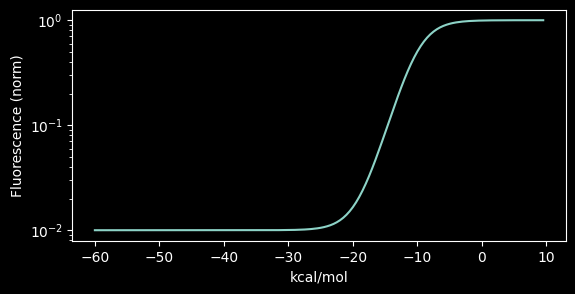

In [23]:
def cal_to_j(E_cal):
    return E_cal * 4.184


def j_to_cal(E_j):
    return E_j / 4.184


def binding_energy_sigmoid(E):
    """ The binding energy is in units of kcal/mol """
    F = (1-0.01)/(1+np.exp(-(E/2 + 5))) + 0.01
    return F


def binding_energy_sigmoid_J(E):
    """ The binding energy is in units of kJ/mol """
    F = (1-0.01)/(1+np.exp(-(E/8.368 + 5))) + 0.01
    return F


E = np.arange(-60, 10, 0.5)

plt.figure(figsize=(14, 3))
ax = plt.subplot(1, 2, 1)
plt.plot(
    E,
    binding_energy_sigmoid(E)
)
plt.xlabel('kcal/mol')
plt.ylabel('Fluorescence (norm)')
plt.yscale('log')


print('Fluorescence is at the 50% point at: ', E[np.argmax(binding_energy_sigmoid(E) >= 0.5)], ' kcal')

print('\nAt -3kcal: ', binding_energy_sigmoid(-3))
print('\nAt -10kcal: ', binding_energy_sigmoid(-10))
print('\nAt -22kcal: ', binding_energy_sigmoid(-22))
print('\nAt -38kcal: ', binding_energy_sigmoid(-37))


Now we need to relate the fluorescence to the equilibrium rates. We have previously derived an approximation for this in the following manner, where $F = $ fluorescence, $D = $ free DNA, $S = $ sRNA, $SD = $ bound DNA, $k_a = $ association rate, $k_d = $ dissociation rate, and $K = $ equilibrium constant:

$$F = \frac{[D]}{([D] + [SD])} $$
$$\frac{1}{F} - 1 = \frac{[SD]}{[D]}$$

We already know the equilibrium constant from $\Delta G$:

$$K = e^{- \Delta G / RT} = \frac{k_a}{k_d} = \frac{[Product]}{[Reactants]} = \frac{[SD]}{[S][D]}$$

We also know that for different fluorescences, different forward and reverse rates must be in play.

$$F = 1 \to k_d >> k_a $$
$$F = 0.001 \to k_d << k_a $$
$$F = 0.5 \to [D] = [SD] \to \frac{k_a}{k_d} = \frac{[SD]}{[S][D]} \approx \frac{1}{[S]} $$
$$F = 0.25 \to [D] = 3[SD] \to \frac{k_a}{k_d} = \frac{3[SD]}{[S][D]} \approx \frac{3}{[S]} $$

$$\frac{k_a}{k_d} \approx \frac{1}{[S]} \big( \frac{1}{F} - 1 \big) $$

In the code above, we have fit a sigmoid curve to the data in the research paper. This fit curve gives

$$F(\Delta G) \approx \frac{1 - 0.01}{1 + e^{-(\Delta G / 2 + 5)}} + 0.01 $$

If we expand this out and make fluorescence dependent on the minimum free energy of binding $\Delta G$:

$$K = \frac{k_a}{k_d} \approx \frac{1}{[S]} \big( \frac{1 - 0.01}{\frac{1}{1 + e^{-(\Delta G / 2 + 5)}} + 0.01} - 1 \big) $$

Since we have also estimated a constant value for association constant $k_a$, this would be used to find the dissociation constant. The only question is what to do with the S term in the final equation. Since we know that at half the normalised fluorescence $F = 0.5$, the equilibrium constant should be equal to 1 ($K = 1$), as the ratio of bound to unbound species should be 1. From this, we can find the concentration $[S]$ that fulfills the equation.


Text(0.5, 1.0, 'k_d, [S] = 0.98mol')

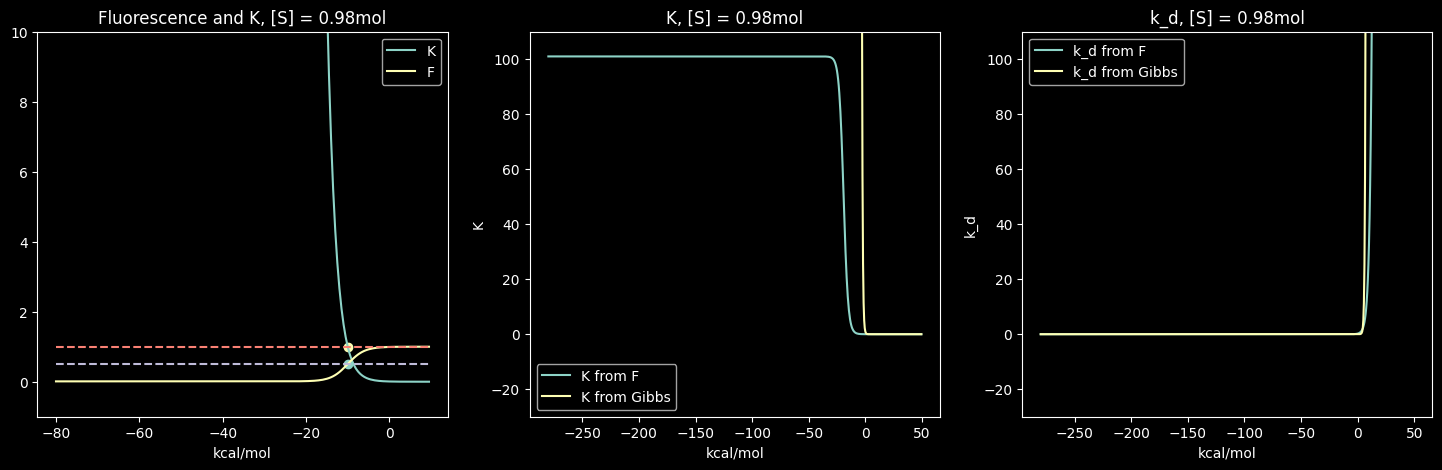

In [24]:
def F(E):
    """ kcal/mol """
    F = (1-0.01)/(1+np.exp(-(E/2 + 5))) + 0.01
    return F
    # return 1/(1+np.exp(-(E/3 + 5))) + 0.01


def gibbs_K_cal(E):
    """ In kcal/mol. dG = - RT ln(K) """
    RT = 1.987 * 310
    E = E * 1000
    K = np.exp(-E/(RT))
    return K


def equilibrium_constant_fluorescence(E, initial):
    """ The energy input E is \Delta G in kcal/mol """
    return 1/initial * (1/F(E) - 1)


E = np.arange(-80, 10, 0.5)
E_F_half = E[np.argmax(F(E) >= 0.5)]
initial = np.round(1/1 * (1/F(E_F_half) - 1), 2)
k_a = 0.0015


plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 3, 1)
plt.plot(
    E,
    equilibrium_constant_fluorescence(E, initial),
    label='K'
)
plt.xlabel('kcal/mol')
# plt.yscale('log')
plt.plot(
    E,
    F(E),
    label='F'
)
plt.scatter(E_F_half, F(E_F_half))
plt.scatter(E_F_half, equilibrium_constant_fluorescence(E_F_half, initial))
plt.plot(E, np.ones_like(E) * F(E_F_half), '--')
plt.plot(E, np.ones_like(E) * equilibrium_constant_fluorescence(E_F_half, initial), '--')
plt.ylim(-1, 10)
plt.legend()
plt.title(f'Fluorescence and K, [S] = {initial}mol')

ax = plt.subplot(1, 3, 2)
E2 = np.arange(-280, 50, 0.5)
plt.plot(E2, equilibrium_constant_fluorescence(E2, initial), label='K from F')
plt.plot(E2, gibbs_K_cal(E2), label='K from Gibbs')
plt.legend()
plt.xlabel('kcal/mol')
plt.ylabel('K')
plt.ylim(-30, 110)
plt.title(f'K, [S] = {initial}mol')

ax = plt.subplot(1, 3, 3)
plt.plot(E2, k_a/equilibrium_constant_fluorescence(E2, initial), label='k_d from F')
plt.plot(E2, k_a/gibbs_K_cal(E2), label='k_d from Gibbs')
plt.legend()
plt.xlabel('kcal/mol')
plt.ylabel('k_d')
plt.ylim(-30, 110)
plt.title(f'k_d, [S] = {initial}mol')




In this case, $[S]$ turned out to be roughly equal to 1 mol for the $\Delta G$ where F = 0.5 the same as that for making $K = 1$, which turned out to be roughly around $\Delta G = - 10$ kcal/mol.
For comparison, the original equation for K and $\Delta G$ is plotted as well and shows a much faster increase past 1, around -1 kcal/mol.

Text(0.5, 1.0, 'k_d from Gibbs, k_a = 0.0015')

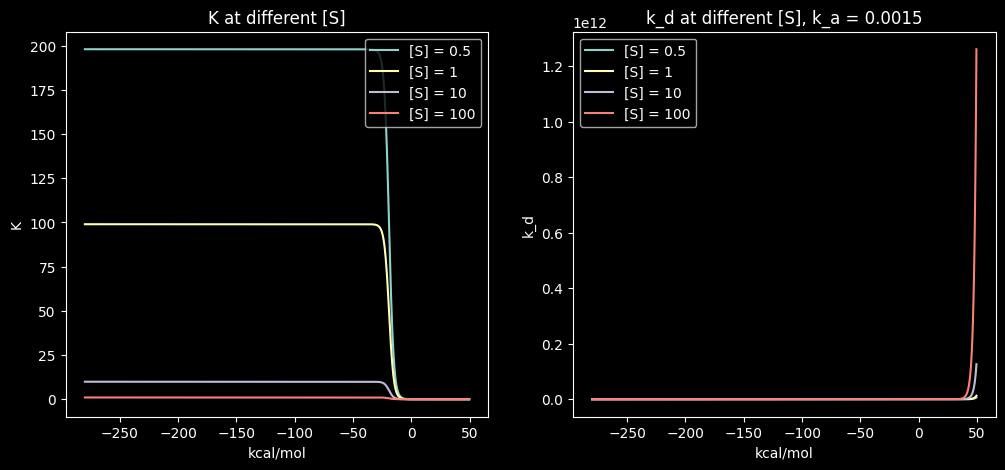

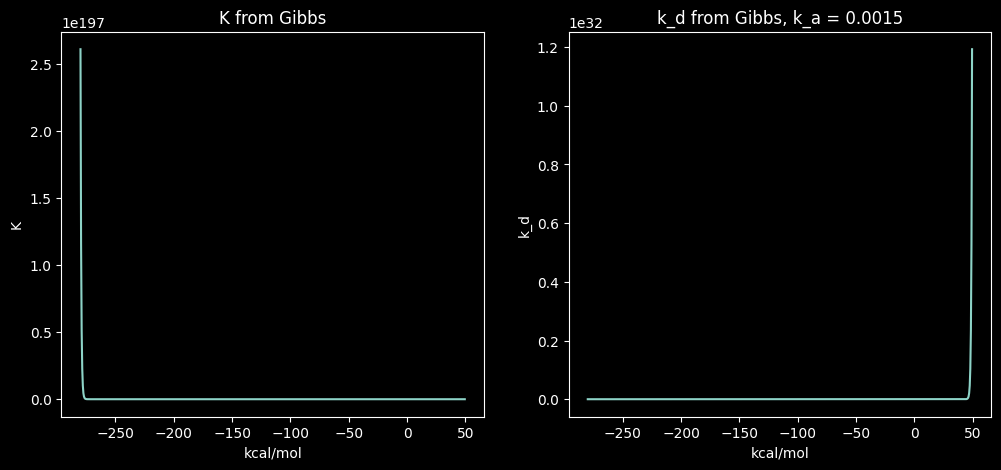

In [25]:
S = [0.5, 1, 10, 100]

plt.figure(figsize=(12, 5))
for s in S:
    ax = plt.subplot(1,2,1)
    plt.plot(E2, equilibrium_constant_fluorescence(E2, s), label=f'[S] = {s}')
    ax = plt.subplot(1,2,2)
    plt.plot(E2, k_a/equilibrium_constant_fluorescence(E2, s), label=f'[S] = {s}')

ax = plt.subplot(1,2,1)
plt.legend()
plt.xlabel('kcal/mol')
plt.ylabel('K')
plt.title('K at different [S]')

ax = plt.subplot(1,2,2)
plt.legend()
plt.xlabel('kcal/mol')
plt.ylabel('k_d')
plt.title(f'k_d at different [S], k_a = {k_a}')


# Comparison to Gibbs
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.plot(E2, gibbs_K_cal(E2))
plt.xlabel('kcal/mol')
plt.ylabel('K')
plt.title('K from Gibbs')

ax = plt.subplot(1,2,2)
plt.plot(E2, k_a/gibbs_K_cal(E2))
plt.xlabel('kcal/mol')
plt.ylabel('k_d')
plt.title(f'k_d from Gibbs, k_a = {k_a}')



In [26]:
K_G = gibbs_K_cal(E2)
K_F = equilibrium_constant_fluorescence(E2, initial)
print('dG at which K from Gibbs is 1:\t\t\t', E2[np.argmax(K_G <= 1)])
print('dG at which K from Fluorescence is 1:\t\t',E2[np.argmax(K_F <= 1)])

print('K from Gibbs at -100 kcal:\t\t\t', gibbs_K_cal(-100))
print('K from Fluorescence at -100 kcal:\t\t\t', equilibrium_constant_fluorescence(-100, initial))


dG at which K from Gibbs is 1:			 0.0
dG at which K from Fluorescence is 1:		 -9.5
K from Gibbs at -100 kcal:			 3.204680085638281e+70
K from Fluorescence at -100 kcal:			 101.0204081632653


From above calculations, the $\Delta G$ at which K is equal to 1 is $\Delta G = 0 $ kcal for K derived from the Gibbs equation, while for the K derived from the fitted fluorescence curve it is $\Delta G \approx -10 $ kcal. It now takes a more negative $\Delta G$ for the equilibrium constant to reach a balance between forward and reverse reaction rates. This means that circuit components must interact much more strongly to be considered binding.

At the same time, the K derived from fluorescence increases more quickly once it is past the $K = 1$, meaning that as soon as any RNA is binding strongly enough, it will bind much more strongly that from the Gibbs free energy case. Therefore, the new energy approximation curve will be biased against RNAs that bind in the intermediate range.

In [27]:
stop

NameError: name 'stop' is not defined

# It was all wrong

The null circuit (when nothing should be interacting) has a significantly high ratio of bound / unbound, which should be close to 0 when nothing is interacting.
K_eq should be small when F is high. When F is 0, K_eq should be huge (so that the percentage of unbound/bound is very high).

- F as exponential decay 
- Fluorescence can't actually be used as a direct mapping
    - have to account for intermediate 
    - F is unbound proteins
    - have to translate the unbound / bound RNA 
- start with thinking about the system and how it works

## Rederivation

To parameterise the binding of RNAs over different binding energies, the fluorescence curve from the paper can be used. High fluorescence means high expression of the fluorescent protein, which means a lot of mRNA that can be read, which means a lot of unbound RNA. Low fluorescence means all the mRNA has been bound up by other RNAs and cannot be used to produce proteins. However, the fluorescence curve is only a proxy for RNA through the concentration of fluorescent protein. 

While fluorescence is therefore roughly equivalent to protein concentration, this is equivalent to the proportion of all RNA that is unbound and needs to map to the equilibrium constant through some kind of function. With S = unbound strand, D = unbound strand, and SD = bound strand, we have:

F: fluorescence
 
$ F \approx ([S] + [D]) / ([S] + [D] + [SD]) $

K = f(F)

K = k_a / k_d

r = ([S] + [D] / [SD])

D = total mRNA
S = unbound sRNA

G = 0       m = 1 * D       K_eq = 0
G = -10     m = 0.5 * D     K_eq = 1
G = -100    m = 0           K_eq = inf





From F og:
G = 0:  6.67011810007212e-05
G = -10:  0.009801980198019802
G = -100:  0.99
From F new:
G = 0:  -0.009932620530009146
G = -10:  0.0
G = -100:  3.4934271057485094e+17


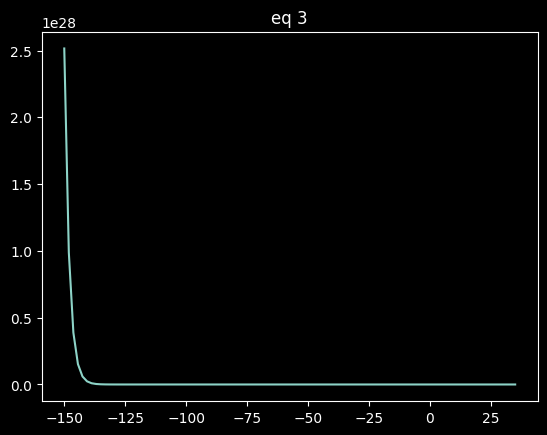

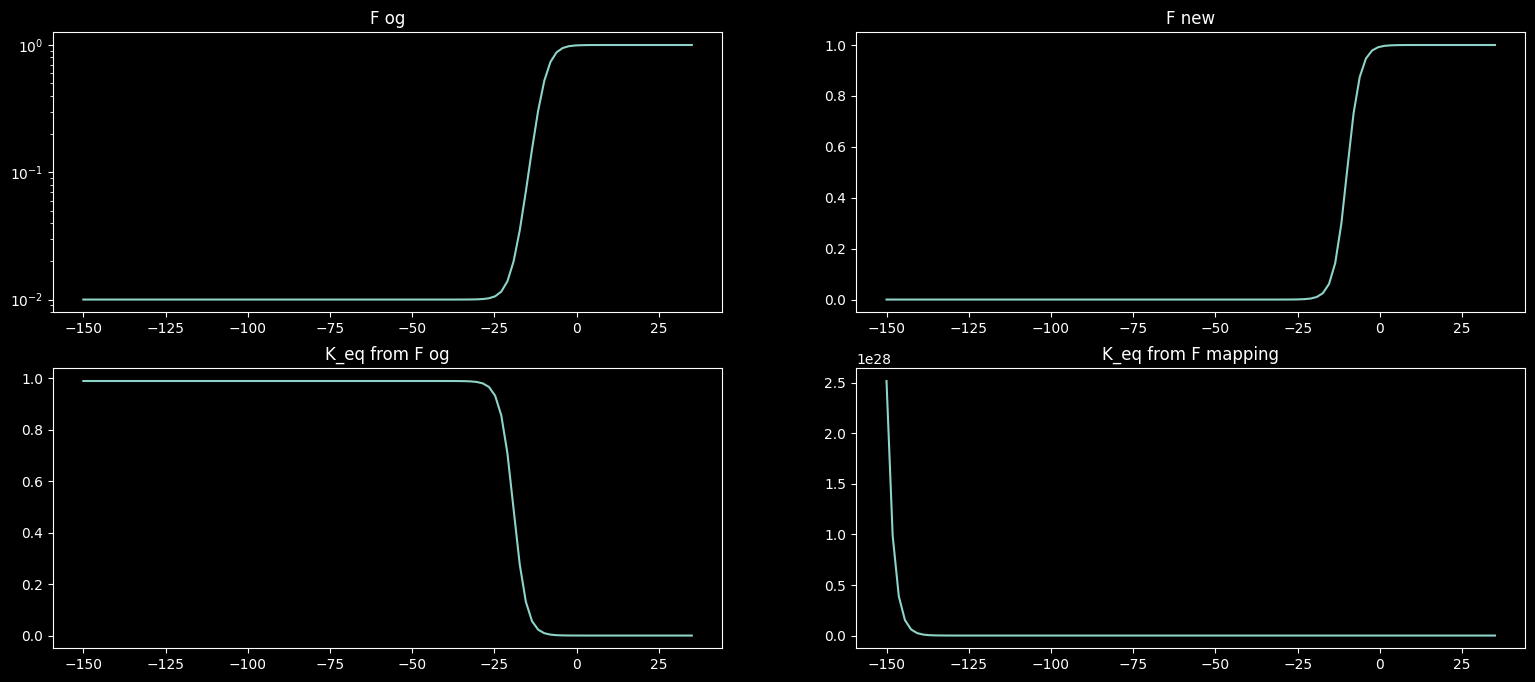

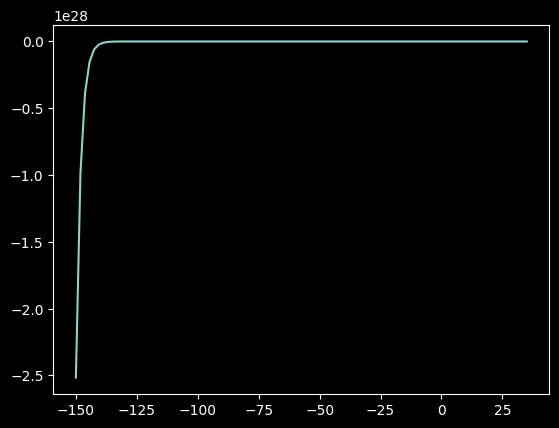

In [124]:
def F(E):
    """ kcal/mol """
    a = -0.5
    b = 10
    leak = 0.01
    Fs = np.exp(a * (E + b))
    return (1 - leak) / (1 + Fs) + leak
    # F = (1-0.01)/(1+np.exp(-(E/2 + 5))) + 0.01
    # return F


def equilibrium_constant_fluorescence(E, initial):
    """ The energy input E is \Delta G in kcal/mol """
    return 1/initial * (1/F(E) - 1)


def F2(G):
    # =SUM($B$7*(EXP(-$G$8*(F16+$G$9))))
    alpha = -0.5
    B = 10
    Fs = np.exp(- alpha * (G + B))
    return Fs / (Fs + 1)


def equilibrium_constant_fluorescence2(G, initial):
    """ The energy input E is \Delta G in kcal/mol """
    return (1 - 2*F2(G)) / (initial * F2(G))
    # Equivalent:
    # return 1/initial * (1/F2(G) - 2) 


def equilibrium_constant_fluorescence3(G, initial, initial_m):
    """ The energy input E is \Delta G in kcal/mol """
    return 1 / (initial * F2(G)) - 1 / initial - 1 / initial_m


Gs = np.linspace(-150, 35, 100)
initial = 100
initial_m = 100

print('From F og:')
print('G = 0: ', equilibrium_constant_fluorescence(0, initial=initial))
print('G = -10: ', equilibrium_constant_fluorescence(-10, initial=initial))
print('G = -100: ', equilibrium_constant_fluorescence(-100, initial=initial))

print('From F new:')
print('G = 0: ', equilibrium_constant_fluorescence2(0, initial=initial))
print('G = -10: ', equilibrium_constant_fluorescence2(-10, initial=initial))
print('G = -100: ', equilibrium_constant_fluorescence2(-100, initial=initial))


plt.figure()
plt.plot(Gs, equilibrium_constant_fluorescence3(Gs, initial, initial_m))
plt.title('eq 3')

plt.figure(figsize=(19, 8))
ax = plt.subplot(2,2,1)
plt.plot(Gs, F(Gs))
plt.title('F og')
plt.yscale('log')
ax = plt.subplot(2,2,2)
plt.plot(Gs, F2(Gs))
plt.title('F new')
# plt.yscale('log')
ax = plt.subplot(2,2,3)
plt.title('K_eq from F og')
plt.plot(Gs, equilibrium_constant_fluorescence(Gs, initial=initial))
# plt.yscale('log')
ax = plt.subplot(2,2,4)
plt.title('K_eq from F mapping')
plt.plot(Gs, equilibrium_constant_fluorescence2(Gs, initial=initial))
# plt.yscale('log')

plt.figure()
plt.plot(Gs, equilibrium_constant_fluorescence(Gs, initial=initial) - equilibrium_constant_fluorescence2(Gs, initial=initial))


B max is  250000.0


<AxesSubplot: >

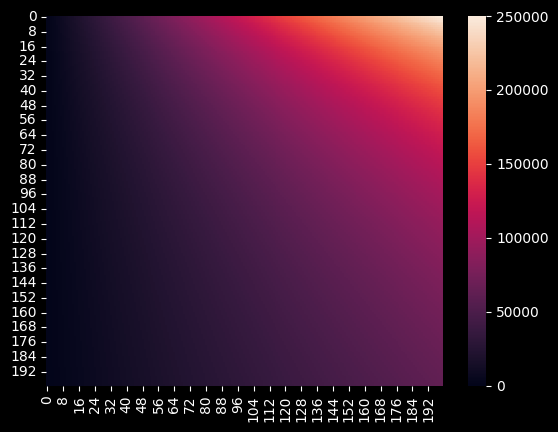

In [111]:
S = np.linspace(0, 50, 200)
# m = np.expand_dims(np.arange(0, 200), axis=1)

def B(m, S, ka, kd):
    """ At steady state """
    return S * m * (ka / kd)
    # return kd * B - ka * S * m

ka = 5000
kd = np.expand_dims(np.linspace(1, 4, 200), axis=1)
m = 1

print('B max is ', B(m, S, ka, kd).max())

sns.heatmap(B(m, S, ka, kd))


/var/folders/89/b14m_l9d4h58lnx67_8_2p440000gn/T/ipykernel_40410/2701242946.py:5: RuntimeWarning: invalid value encountered in divide
  return np.divide((-1 + np.sqrt(1 + 8*K*m0)), 4*K)


Text(0, 0.5, '# molecules')

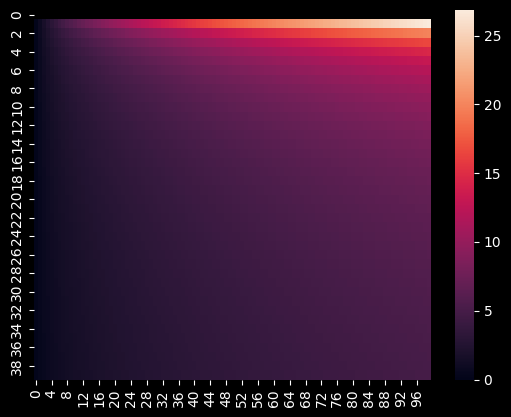

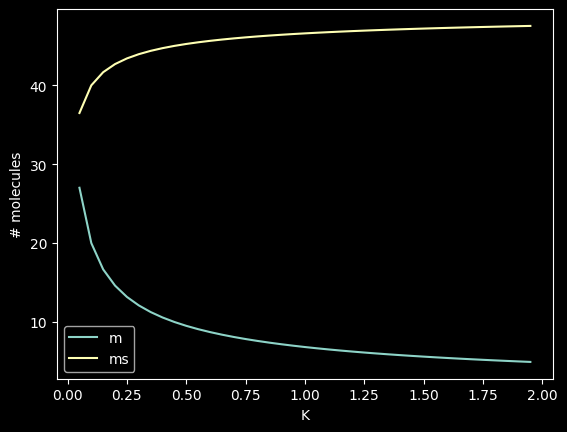

In [151]:
m0 = np.arange(100)
K = np.expand_dims(np.arange(0, 2, 0.05), axis=1)

def mbar(K, m0):
    return np.divide((-1 + np.sqrt(1 + 8*K*m0)), 4*K)

def msbar(K, m0):
    return K * np.power(mbar(K, m0), 2)

sns.heatmap(mbar(K, m0))

plt.figure()
plt.plot(K, mbar(K, 100))
plt.plot(K, msbar(K, 100))
plt.legend(['m', 'ms'])
plt.xlabel('K')
plt.ylabel('# molecules')

In [138]:
K = np.arange(0, 10, 0.1)
K = 1
ka = 1
kd = K / ka


def dmdt(t, ms, args):

    return kd * ms - ka * np.power(m, 2)


def one_step_de_sim_expanded(spec_conc, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = np.prod(
        np.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = np.prod(
        np.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


def bioreaction_sim_expanded(t, y,
                             args,
                             inputs, outputs,
                            #  signal, signal_onehot: np.ndarray,
                             forward_rates=None, reverse_rates=None):
    return one_step_de_sim_expanded(
        spec_conc=y, inputs=inputs,
        outputs=outputs,
        forward_rates=forward_rates,
        reverse_rates=reverse_rates) #+ signal(t) * signal_onehot


import diffrax as dfx

d_term = dfx.ODETerm(dmdt)


m0 = np.array([100, 0])
v = dfx.diffeqsolve(d_term, solver=dfx.Tsit5(), t0 = 0, t1=100, dt0=0.1, y0=m0, saveat=dfx.SaveAt(t0=True, t1=True, steps=True))

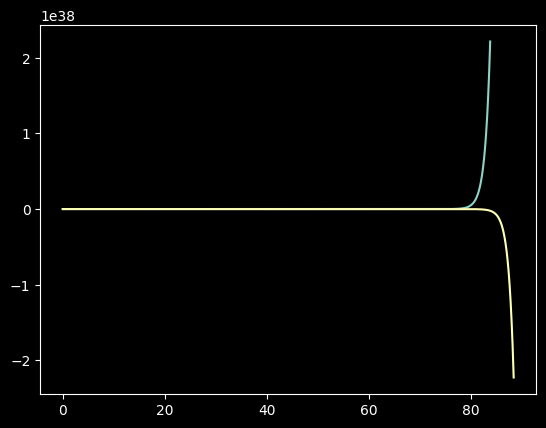

In [141]:
plt.plot(v.ts, v.ys)

## Tests

How does the new RNA equilibrium constant calculation change real samples? Let's look at some test circuits where we know they have weak / medium / strong binding energies and compare their dynamics between the Gibbs free energy and reparameterised equilibrium constant calculation methods.

Get outer level imports first...

In [ ]:
import os
import sys

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)

from copy import deepcopy
from tests_local.shared import five_circuits, CONFIG
from src.utils.circuit.agnostic_circuits.circuit_manager_new import CircuitModeller

config = deepcopy(CONFIG)

Initialise circuits, then change the equilibrium constants and binding rates of dissociation to pull from the fluorescence-based approximation of binding.

In [ ]:
circuits, config, data_writer = five_circuits(
    config, data_writer=None)



In [ ]:
def init_circuits(circuits):
    circuits = CircuitModeller(result_writer=data_writer, config=config).batch_circuits(
        circuits=circuits,
        write_to_subsystem=True,
        batch_size=config['simulation'].get('batch_size', 100),
        methods={
            "compute_interactions": {},
            "init_circuit": {}
            # "simulate_signal_batch": {'ref_circuit': None,
            #                           'batch': config['simulation']['use_batch_mutations']},
            # "write_results": {'no_visualisations': config['experiment']['no_visualisations'],
            #                   'no_numerical': config['experiment']['no_numerical']}
        })
    return circuits

In [ ]:
circuits = init_circuits(circuits)

Done:  0:00:03.851093
Steady states:  100  iterations.  9  left to steady out.  0:00:03.670845
Steady states:  200  iterations.  2  left to steady out.  0:00:06.638923
Done:  0:00:06.643907
Done:  0:00:02.974996


KeyboardInterrupt: 

In [ ]:
config['signal']['function_kwargs']['target'] = 0.5
config['simulation']['t1'] = 1500
config['simulation']['dt'] = 0.01

def sim_write(circuits):
    circuits = CircuitModeller(result_writer=data_writer, config=config).batch_circuits(
        circuits=circuits,
        write_to_subsystem=True,
        batch_size=config['simulation'].get('batch_size', 100),
        methods={
            # "init_circuit": {}
            "simulate_signal_batch": {'ref_circuit': None,
                                    'batch': config['simulation']['use_batch_mutations']},
            "write_results": {'no_visualisations': config['experiment']['no_visualisations'],
                            'no_numerical': config['experiment']['no_numerical']}
        })
    return circuits



In [ ]:
circuits = sim_write(circuits)

In [ ]:

def vis_sim(circuits):
    output_files = pd.concat([
        pd.read_csv(os.path.join(data_writer.write_dir, c.name, 'output_summary.csv')) for c in circuits
    ], axis=0)

    from IPython.display import SVG, display
    x = output_files[(output_files['out_type'] == 'svg') & (output_files['name'] == 'signal')]
    for out_path, subdir in zip(x['out_path'], x['subdir']):
        print(subdir)
        display(SVG(filename=out_path))

In [ ]:
vis_sim(circuits)